# Gridded Data Station Subsetting on closest model point

This program is a replacement for the suite of programs like `HROISST_Station.py` and `NARR_daily_WindsSFCtemp_Station`.  Previous iterations of this program would use netcdf files from archive centers to first, locate the closest gridpoint, then extract that point from all successive files and combine the results into a single EPIC flavored netcdf file.

**Common Datasets**
- NARR 3hrly or daily data
- NCEP/NCAR Reanalysis data
- erddap hosted JPL MUR sst data
- etopo5 or other bathymetry

Primary functions to replace and motivation for this notebook
- Stop supporting python 2.7 (support 3.8 or greater)
- Stop outputting anything EPIC related files
- use native "find nearest" for xarray... may not truly take into account lat/lon is not consistent km as you go furthur north like great circle would.  Not sure this is actually an issue though unles your grid is super coarse... 

Tasks that are addressed below:
- read from multiple files (often parameters are in seperate files for seperate years)
- read from erddap if available 
- filter 3hr winds (3pt triangle filter shown), but you can use any other filter on any other parameter
- take daily, hourly or monthly input

Inputs:
- station name
- start/end time
- location (lat,lon)
- filter information

In [1]:
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Explore using data from netcdf files

Commonly PJS asks for NARR winds/temp from certain locations (C2, M2)

For netcdf files with parameters that span mulitple files (like NARR or NCEP Reanalysis files where each file is usually just a single parameter plus location/time) you can read them as a multi-file dataset aggregated on similar years (so loop over years for a multi year analysis)

If you only want a single parameter, you can go straight to looping over years or even just use the mfdataset method to open all files.

In [2]:
year = 2022
lat = 71.230
lon = -164.105
site = 'C2'

In [3]:
netcdf_dir = {'datapath':'/Users/bell/in_and_outbox/data_sets/reanalysis_data/NARR/', #NARR Netcdf example
              'dataset':'NARR'}
# netcdf_dir = {'datapath':'/Volumes/External/in_and_outbox/data_sets/reanalyis_data/NCEP-NCAR/daily/', #NCEP Netcdf example
#               'dataset':'NCEP'}

#load muliple files, one year - or multiple years, one measurement type
ds = xa.open_mfdataset(netcdf_dir['datapath']+f'*{year}.nc').load() #<-- pass year in - 

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
# the following is a least distance calculator using the units specified.  
# As one deg of lon and one deg of latitude are not consistantly equal over the entire globe (like one unit of km is) this approach
#  has its numerical limitations and should only be used when a measure of ambiguity is ok.  otherwise, stick to consistent units (km or x/y)
#
# You may need to change the lat/lon variables though for the independent dataset

if netcdf_dir['dataset'] == 'NARR':
    ''' for when grid is in x/y coords'''
    d_lat = ds.lat - lat
    d_lon = ds.lon - lon
    r2_requested = d_lat**2 + d_lon**2
    i_j_loc = np.where(r2_requested == np.min(r2_requested))

    nearest_point = ds.isel(x=i_j_loc[1], y=i_j_loc[0]) #x/y order may need reversal
else:
    if ds.lon.all() >=0:
        ''' for when its 0:360'''
        nearest_point = ds.sel(lat=lat,lon=lon+360,method='nearest')
    else:
        ''' for when its -180:180'''
        pass

In [13]:
ods.AT_21.isel(lat=0,lon=0,depth=0).values

array([-25.797241 , -23.142609 , -23.471329 , -22.580551 , -22.1232   ,
       -21.782013 , -22.937912 , -24.244415 , -24.639267 , -22.822906 ,
       -24.151901 , -23.558151 , -23.051193 , -22.685837 , -22.852142 ,
       -25.176117 , -26.748383 , -27.441772 , -27.982346 , -27.701141 ,
       -27.684387 , -26.920288 , -27.034958 , -26.36586  , -25.174927 ,
       -22.801147 , -21.335037 , -20.32814  , -20.090027 , -19.014496 ,
       -18.656036 , -18.33432  , -18.312744 , -18.867462 , -19.123322 ,
       -19.530334 , -19.808167 , -20.566345 , -19.852066 , -18.34375  ,
       -21.006226 , -22.135834 , -24.501404 , -25.845093 , -27.237137 ,
       -27.84909  , -27.634018 , -26.053299 , -25.37236  , -24.274063 ,
       -24.02945  , -23.893768 , -23.797607 , -24.200073 , -25.256744 ,
       -26.08464  , -26.45224  , -27.006073 , -27.184387 , -27.360825 ,
       -28.49202  , -29.554688 , -30.18161  , -28.604752 , -28.504517 ,
       -27.216522 , -27.655838 , -27.569717 , -30.631851 , -30.5

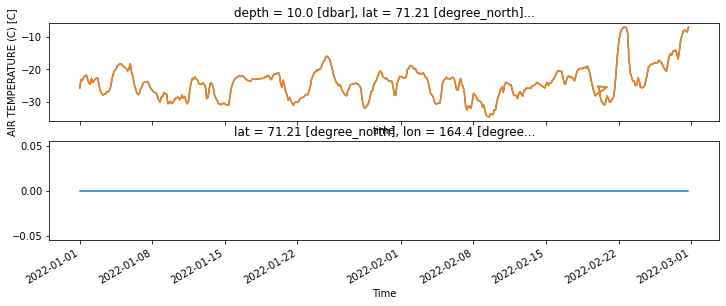

In [14]:
#compare to old method which used python=2.7, EPIC formatted NetCDF data and a Great Circle calculator for nearest point

ods = xa.load_dataset(netcdf_dir['datapath']+'NARR_C2_2022.cf.nc')

fig, ax = plt.subplots(2,figsize=(12, 4), sharex=True)

(nearest_point.air-273.15).plot(ax=ax[0])
ods.AT_21.plot(ax=ax[0])

((nearest_point.air-273.15)-ods.AT_21).plot(ax=ax[1])

assert ((nearest_point.air-273.15).isel(x=0,y=0).values == ods.AT_21.isel(lat=0,lon=0,depth=0).values).all(), 'Methods not equivalent' 

In [ ]:
# often a triangle filter was applied to the 3hr data... you can do the same with the following numpy call
fig, ax = plt.subplots(1,figsize=(12, 4), sharex=True)
ods.AT_21.plot(ax=ax)
ax.plot(ods.time,np.convolve(ods.AT_21[:,0,0,0],[0.25, 0.5, 0.25],'same')) #triangle filter

In [ ]:
start_date = '2022-01-01'
end_date = '2022-02-26'
lat = 56.867
lon = -164.07
site = 'M2'

In [ ]:
## from erddap (SST and ice concentration)

# Could also use this to retrieve bathymetry from erddap hosted files

def NearestFromErddap(server=None,dataset=None,variablename=None,latitude=0,longitude=0,startdate='',enddate=''):
    ''' Given an erddap url and a datasetID, provide the latitude and longitude to get the nearest datavalue within a time window.  
    You will also need to specify the name of the parameter you are interested in, some examples are below.
    
    date format : yyyy-mm-dd
    latitude : -90 to 90
    longitude: try -180:180 or 0:360
    
    NOAA - HROISST: https://coastwatch.pfeg.noaa.gov :: ncdcOisst21Agg_LonPM180 or ncdcOisst21Agg
            sst: err: ice (also all as a 4d function :'( )
    JPL - MUR: https://coastwatch.pfeg.noaa.gov :: jplMURSST41 or jplMURSST41_Lon0360
            analysed_sst; sea_ice_fraction; analysis_error
    UKMET - OSTIA: https://upwell.pfeg.noaa.gov :: nasa_jpl_2fa2_cbe7_cd13.html
    
    OSISAF - EUMET: polarwatch.noaa.gov :: eumetsat_osisaf_ice_conc_nh_ps
    (this outputs and x/y dataset that needs to be merged on to the NH PolarStereographic Grid)
    '''
    
    try:
        if dataset in ['ncdcOisst21Agg_LonPM180','ncdcOisst21Agg']:
            url=f"{server}/erddap/griddap/{dataset}.csvp?{variablename}[({startdate}):1:({enddate})][(0.0):1:(0.0)][({latitude}):1:({latitude})][({longitude}):1:({longitude})]"
            return pd.read_csv(url,skiprows=0,parse_dates=True,index_col='time (UTC)')
        else:
            url=f"{server}/erddap/griddap/{dataset}.csvp?{variablename}[({startdate}):1:({enddate})][({latitude}):1:({latitude})][({longitude}):1:({longitude})]"
            return pd.read_csv(url,skiprows=0,parse_dates=True,index_col='time (UTC)')
    except:
        return url    
    

In [ ]:
jpl_sst = NearestFromErddap('https://coastwatch.pfeg.noaa.gov','jplMURSST41','analysed_sst',lat,lon,f'{start_date}',f'{end_date}')

In [ ]:
ukmet_sst = NearestFromErddap('https://upwell.pfeg.noaa.gov','nasa_jpl_2fa2_cbe7_cd13','analysed_sst',lat,lon,f'{start_date}',f'{end_date}')

In [ ]:
noaaoi_sst = NearestFromErddap('https://coastwatch.pfeg.noaa.gov','ncdcOisst21Agg_LonPM180','sst',lat,lon,f'{start_date}',f'{end_date}')

In [ ]:
fig, ax = plt.subplots(1,figsize=(16, 2))

jpl_sst['analysed_sst (degree_C)'].plot(ax=ax,label='MUR')
ukmet_sst['analysed_sst (degree_C)'].plot(ax=ax,label='UKMet')
noaaoi_sst['sst (degree_C)'].plot(ax=ax,label='NOAA')
ax.set_ylim([-2,5])
ax.legend()

We can use the same code above to retrieve "ice concentration" information at the same location as well... some even from the same datasource

In [ ]:
jpl_ice = NearestFromErddap('https://coastwatch.pfeg.noaa.gov','jplMURSST41','sea_ice_fraction',lat,lon,f'{year}-01-01',f'{end_date}')

In [ ]:
ukmet_ice = NearestFromErddap('https://upwell.pfeg.noaa.gov','nasa_jpl_2fa2_cbe7_cd13','sea_ice_fraction',lat,lon,f'{year}-01-01',f'{end_date}')

In [ ]:
noaaoi_ice = NearestFromErddap('https://coastwatch.pfeg.noaa.gov','ncdcOisst21Agg_LonPM180','ice',lat,lon,f'{year}-01-01',f'{end_date}')

In [ ]:
fig, ax = plt.subplots(1,figsize=(16, 2))

jpl_ice['sea_ice_fraction (1)'].plot(ax=ax,label='MUR')
ukmet_ice['sea_ice_fraction (1)'].plot(ax=ax,label='UKMet')
noaaoi_ice['ice (1)'].plot(ax=ax,label='NOAA')
ax.set_ylim([-.01,1.01])
ax.legend()

**Todo:**
- Show that the gridded datapoint is near the initial datapoint and include some simple bathymetry or coastlines
- Ouput to csv is straight forward (netcdf -> pandas -> csv)... any other specific formats need descriptions
- Tether into Database for MooringID's or CTD Locations?